In [14]:
import cv2
import numpy as np
import types
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
'''
    Create a class of key set
'''
class KeySet:
    def __init__(self,key,start_x,start_y):
        self.key = key
        self.start_x = start_x
        self.start_y = start_y

In [3]:
keyset = KeySet(2,2,3)

## Encoding data into image 

In [4]:
'''
    Function that convert any type of data message to binary
'''

def messageToBinary(msg):
    if (type(msg) == str):
        return ''.join([format(ord(i), "08b") for i in msg])
    elif (type(msg) == bytes or type(msg) == np.ndarray):
        return [format(i, "08b") for i in msg]
    elif (type(msg) == int or type(msg) == np.uint8):
        return format(msg, "08b")
    else:
        raise TypeError("Please give valid message")

In [5]:
'''
    Function to hide secret message into image
'''

def hideData (image, secret_msg, keyset):
    # calculate maximum byte to be encoded in RGB image
    if(len(image.shape) == 3):
        n = image.shape[0] * image.shape[1] * 3 // 8
    else:
        n = image.shape[0] * image.shape[1] // 8
    if(len(secret_msg) > n):
        raise valeError("Secret message is overflow please give less amount of data or a bigger image")
    
    # use delimeter for knowing ending of string
    secret_msg += "@#@#" 
    
    data_index = 0
    
    binary_secret_msg = messageToBinary(secret_msg)
    
    data_len = len(binary_secret_msg)
    
    # process to hide binary data into image
    # first we check the given image is single channel image (e.g. grayscale image) or 3 channel image rgb image
    i, j = keyset.start_x, keyset.start_y
    if (len(image.shape) == 3):
        row,col,channel = image.shape
        for x in range(row):
            for y in range(col):
                r,g,b = messageToBinary(image[i,j,:])
                if (data_index < data_len):
                    image[i,j,0] = int(r[:-1]+ binary_secret_msg[data_index],2)
                    data_index += 1
                if (data_index < data_len):
                    image[i,j,1] = int(g[:-1]+ binary_secret_msg[data_index],2)
                    data_index += 1
                if (data_index < data_len):
                    image[i,j,2] = int(b[:-1]+ binary_secret_msg[data_index],2)
                    data_index += 1
                if (data_index >= data_len):
                    break
                j = (j + keyset.key) % col-1
            i = (i + keyset.key) % row-1
                    
    elif (len(image.shape) == 2):
        row,col = image.shape
        for x in range(row):
            for y in range(col):
                gray = messageToBinary(image[i][j])
                if (data_index < data_len):
                    image[i][j] = int(gray[:-1]+binary_secret_msg[data_index],2)
                    data_index += 1
                else:
                    break
                j = (j + keyset.key) % col-1
            i = (i + keyset.key) % row-1
    else:
        raise valueError("Given image is not valid")
    return image

In [6]:
'''
    Function to take an input image and data
'''
def encodeText(path, keyset):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    print (f'Shape of given image is {image.shape}')
    
    data = input("Enter your message to be encrypted : ")
    
    encode_image = hideData(image, data, keyset)
    filename, filetype = path.split('.')
    filename += "_stego."+filetype
    cv2.imwrite(filename, encode_image)
    
    plt.figure(figsize = (15,15))
    if (len(image.shape) == 3):
        img = mpimg.imread(path,0)
        plt.subplot(1,2,1),plt.imshow(img),plt.title("Original Image")

        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        plt.subplot(1,2,2),plt.imshow(img),plt.title("Encoded Image")
    elif (len(image.shape) == 2):  
        plt.subplot(1,2,1),plt.imshow(image, cmap='gray', vmin=0, vmax=255),plt.title("Original Image")

        plt.subplot(1,2,2),plt.imshow(encode_image, cmap='gray', vmin=0, vmax=255),plt.title("Encoded Image")

    return filename

Shape of given image is (256, 256)
Enter your message to be encrypted : Secret Message


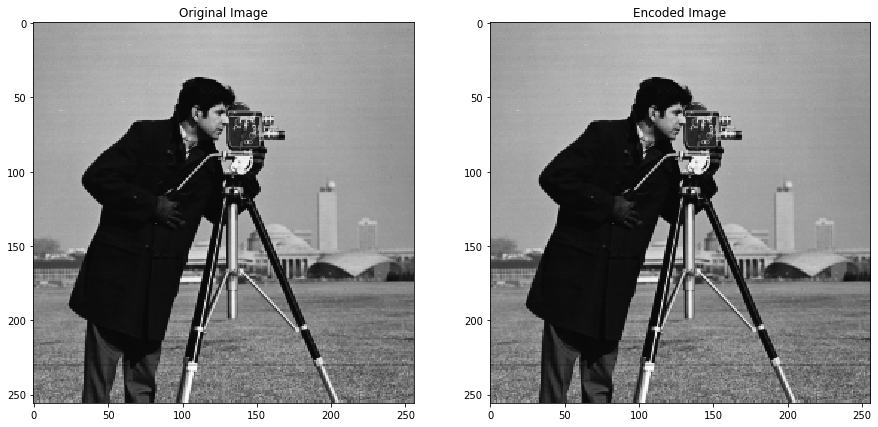

In [7]:
encoded_filename = encodeText("Cover_1.png", keyset)

## Decode data from image

In [8]:
'''
    Function to extract the data from in encoded image
'''
def extractData(image, keyset):
    
    binary_data = ""
    # check whether input image is single or triple channel
    i, j = keyset.start_x, keyset.start_y
    if (len(image.shape) == 3):
        row,col,channel = image.shape
        for x in range(row):
            for y in range(col):
                r,g,b = messageToBinary(image[i][j][:])
                binary_data += r[-1] 
                binary_data += g[-1] 
                binary_data += b[-1]
                j = (j + keyset.key) % col-1
            i = (i + keyset.key) % row-1
    elif(len(image.shape) == 2):
        row,col = image.shape
        for x in range(row):
            for y in range(col):
                gray = messageToBinary(image[i][j])
                binary_data += gray[-1]
                j = (j + keyset.key) % col-1
            i = (i + keyset.key) % row-1
    else:
        raise TypeError("Input image is not valid")
            
        
    
    all_byte = [binary_data [i: i+8] for i in range (0, len(binary_data),8)]
    
    decode_data = ""
    
    for byte in all_byte:
        decode_data += chr(int(byte, 2))
        if (decode_data[-4:] == "@#@#"):
            break
            
    return decode_data[:-4]

In [9]:
'''
    Function to read an encoded image and give text data
'''
def decodeText(path, keyset):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    text = extractData(image, keyset)
    
    return text

In [10]:
decodeText(encoded_filename, keyset)

'Secret Message'

## Code Check

In [11]:
# From KeySet Generate keyset that is private key set for sender and receiver
s = "Enter the reqiured keyspace seperated by space i.e\n1)Start x position\n2)Start y position\n3)Secret Key\n"
s += "Note : start x and start y should not be prime no. and Secrek key should be prime number\n"
x,y,key = list(map(int,input(s).split(' ')))
keyset = KeySet(x,y,key)

Enter the reqiured keyspace seperated by space i.e
1)Start x position
2)Start y position
3)Secret Key
Note : start x and start y should not be prime no. and Secrek key should be prime number
56 89 113


Shape of given image is (256, 256)
Enter your message to be encrypted : Disclaimer: This email and any files transmitted with it are confidential and intended solely for the use of the individual or entity to whom they are addressed. If you have received this email in error please notify the system manager. This message contains confidential information and is intended only for the individual named. If you are not the named addressee you should not disseminate, distribute or copy this e-mail. Please notify the sender immediately by e-mail if you have received this e-mail by mistake and delete this e-mail from your system. If you are not the intended recipient you are notified that disclosing, copying, distributing or taking any action in reliance on the contents of this information is strictly prohibited.



Decoded message of image is : Disclaimer: This email and any files transmitted with it are confidential and intended solely for the use of the individual or entity to whom they are

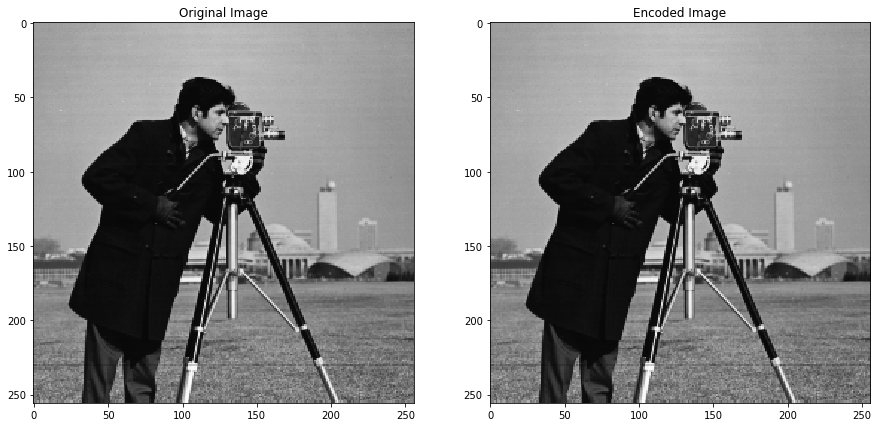

In [12]:
# Encode message in Grayscale image
# Encode the message into image using keyset
keyset = KeySet(258,165,13)
output_Image_1 = encodeText("Cover_1.png", keyset)

print('\n\n')
# Decode message from stego image
print(f'Decoded message of image is : {decodeText(output_Image_1, keyset)}')

Shape of given image is (222, 223, 3)
Enter your message to be encrypted : Disclaimer: This email and any files transmitted with it are confidential and intended solely for the use of the individual or entity to whom they are addressed. If you have received this email in error please notify the system manager. This message contains confidential information and is intended only for the individual named. If you are not the named addressee you should not disseminate, distribute or copy this e-mail. Please notify the sender immediately by e-mail if you have received this e-mail by mistake and delete this e-mail from your system. If you are not the intended recipient you are notified that disclosing, copying, distributing or taking any action in reliance on the contents of this information is strictly prohibited.



Decoded message of image is : Disclaimer: This email and any files transmitted with it are confidential and intended solely for the use of the individual or entity to whom they 

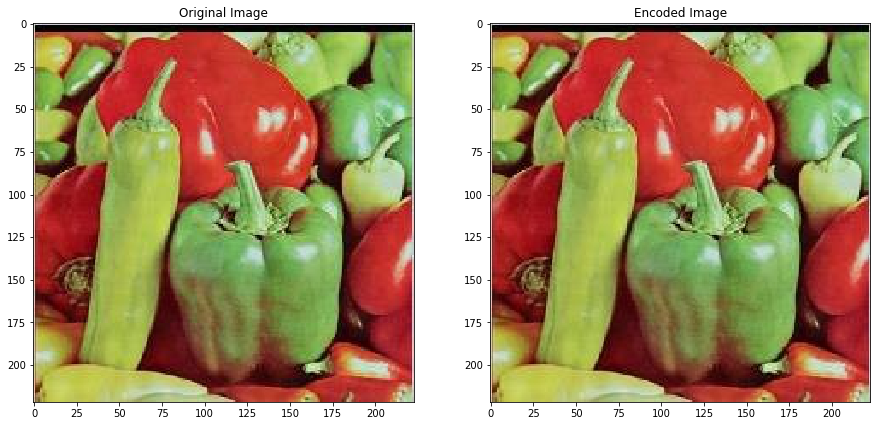

In [15]:
# Encode message in RGB image

# Encode the message into image using keyset
output_Image_1 = encodeText("Cover_2.png", keyset)

print('\n\n')
# Decode message from stego image
print(f'Decoded message of image is : {decodeText(output_Image_1, keyset)}')